# GAN-Control: Explicitly Controllable GANs
Reference:
> Github: https://github.com/amazon-science/gan-control <br>
> Research Paper: https://arxiv.org/pdf/2101.02477.pdf <br>

```
@InProceedings{Shoshan_2021_ICCV,
    author    = {Shoshan, Alon and Bhonker, Nadav and Kviatkovsky, Igor and Medioni, G\'erard},
    title     = {GAN-Control: Explicitly Controllable GANs},
    booktitle = {Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV)},
    month     = {October},
    year      = {2021},
}
```

**Remark: For part two of Project 4 - Face Generation, we will use the pretrained model from this repository.

The image dataset is `FFHQ (Flickr-Face-HQ)` Dataset which consisted of 70,000 high-resolution images of individually of vrious ages, ethnicities, and background. This enable the model to learn on various controllable attributes like age, pose, and expression.

In [ ]:
from IPython.display import clear_output
!git clone https://github.com/amazon-science/gan-control.git
!mkdir -p resources/gan_models
!gdown --id 19v0lX69fV6zQv2HbbYUVr9gZ8ZKvUzHq -O resources/gan_models/controller.tar.gz
!tar -xzvf resources/gan_models/controller.tar.gz -C resources/gan_models/
clear_output()

In [ ]:
import os
import torch
from PIL import Image
import pandas as pd
import sys

sys.path.append('/content/gan-control/src')

from gan_control.inference.controller import Controller
controller_path = '/content/resources/gan_models/controller_age015id025exp02hai04ori02gam15_temp'
controller = Controller(controller_path)
clear_output()

INFO:gan_control.inference.inference: Calc mean_w_latents...
INFO:gan_control.inference.inference:Calc mean_w_latents...


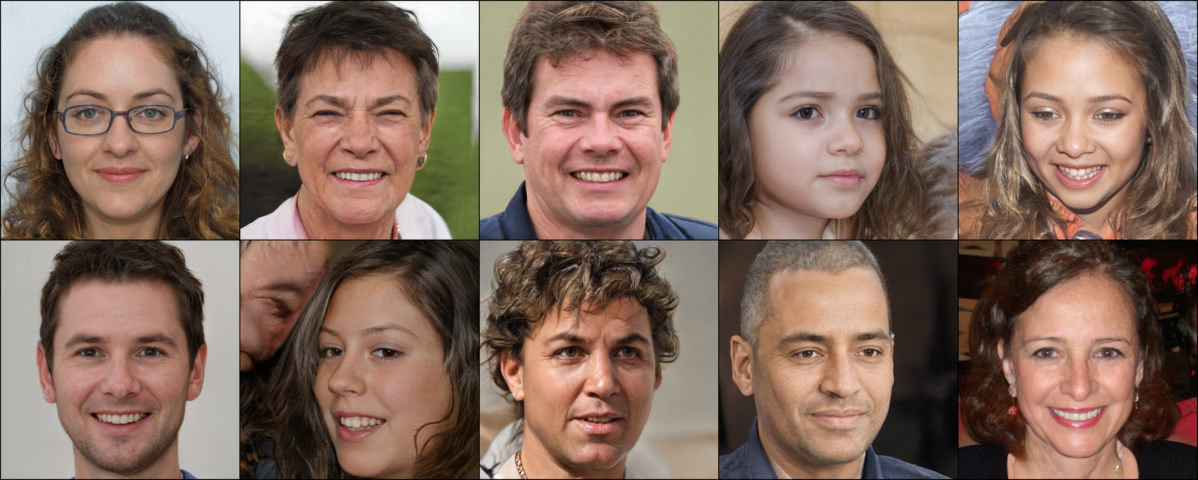

In [ ]:
batch_size = 10
truncation = 0.7
resize = 480
nrow = batch_size // 2

initial_image_tensors, initial_latent_z, initial_latent_w = controller.gen_batch(
    batch_size=batch_size,
    truncation=truncation
)
controller.make_resized_grid_image(initial_image_tensors, resize=resize, nrow=nrow)

## Sample 1
Three Disentangling Features:
1. **Pose Control** := (Control parameter: Euler angles (yaw, pitch, roll))
> Yaw := the rotation around the verticle axis. yaw = 30 would mean the object is rotated 30 degrees to the right (in the clockwise direction) <br><br>
> Pitch := the rotation around the lateral axis. pitch = -10 would mean mean the face has downward tilt from the horizontal plane <br><br>
> Roll := the rotation around the longitudinal axis. We set the roll to 0 because it makes the image look disoriented, especially when the roll value is extreme.

2. **Age Control** := the scalar value that present the age of the person. For instance, the number 25 correspond to 25 years old.

3. **Hair Color** := a set of values that defines a color in RGB color space. The value correspond to intensities of red, green, and blue light. In this particular sameple, the combination of ```bloand_color = torch.tensor([[0.73 , 0.62 , 0.36]])``` yield a blond color.

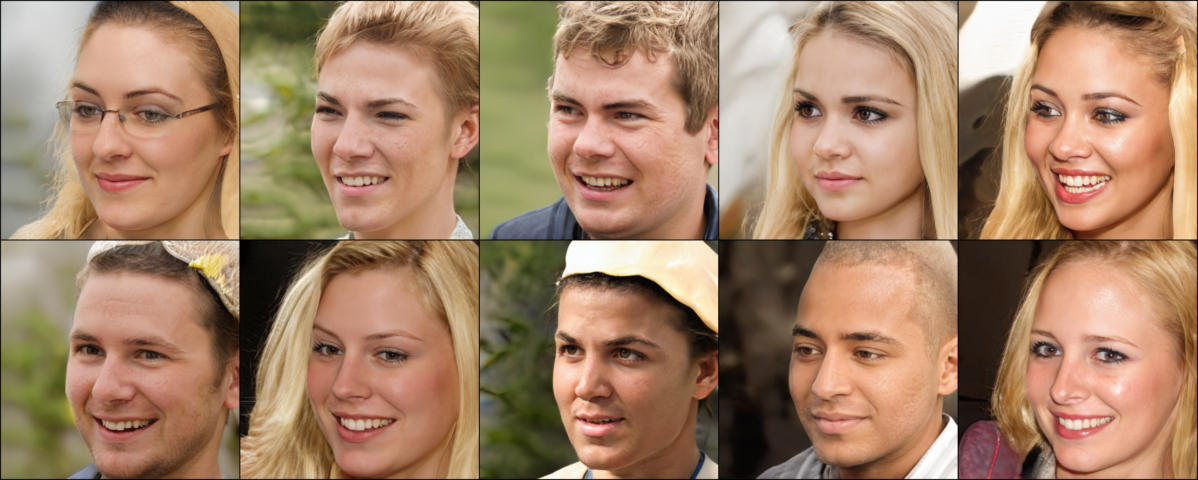

In [ ]:
pose_control = torch.tensor([[30., -10., 0.0]])
age_control = torch.tensor([[25.]])
bloand_color = torch.tensor([[0.73 , 0.62 , 0.36]])

image_tensors, _, modified_latent_w = controller.gen_batch_by_controls(
    latent=initial_latent_w,
    input_is_latent=True,
    orientation=pose_control,
    age=age_control,
    hair=bloand_color
)
controller.make_resized_grid_image(image_tensors, resize=resize, nrow=nrow)

## Sample 2
Three Disentangling Features
1. **Pose** := setting the pose to make the person facing front (looking straight at you!)

2. **Age** := representing an elderly individual by setting the age to 70 years old

3. **Color** := make some adjustment to the color of the hair to be grayish white color.

This combination make the resulting image look really realistic as if we're looking at an actual elderly person and not generated by artificial intelligence!

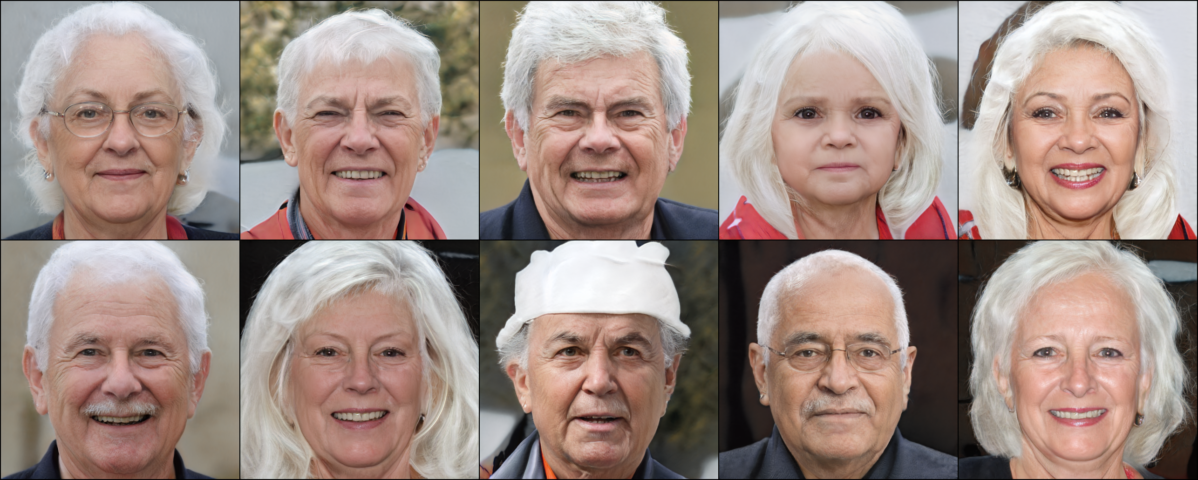

In [ ]:
pose_control = torch.tensor([[0., 0., 0.]]) # Facing Front
age_control = torch.tensor([[70.]])
white_hair_color = torch.tensor([[0.90, 0.90, 0.90]]) # RGB Color

image_tensors, _, modified_latent_w = controller.gen_batch_by_controls(
    latent=initial_latent_w,
    input_is_latent=True,
    orientation=pose_control,
    age=age_control,
    hair=white_hair_color
)

controller.make_resized_grid_image(image_tensors, resize=resize, nrow=nrow)

## Sample 3
Three Disentangling Features

In this example, we introduced additiona featurse to control the facial expression and illumination.

1. **Facial Expression** := The attributed has been stored in the dataframe in a pickle file. There are a total of 1000 expressions and the dimension of each datapoint is `expressions[0].shape = (64,)`.
> Experimenting with different index would yield different result. In our sample, we selected the data poitn at index 10 which resulted in "Big Smile😊"


2. **Illumination** := this control parameter is a 27-dimensional sphereical harmonic vectors, representing lighting information.
> We experiment with various combination in the `sh_eval_basis_1(0, 0, 1)` section and the `strength` of the light (basically how bright the light is). For our sample, the combination yield a front facing illumination that resemble a flashlight when taking picture from camera.

3. **Color** := this is the same control parameter that make the color of the hair changes. We selected black for this example.

<ipython-input-6-5baf447f0a25>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  illumination_control = torch.tensor([sh_eval_basis_1(0, 0, 1)]) * strength # Front Facing Illumunation


Total number of facial expression: 1000


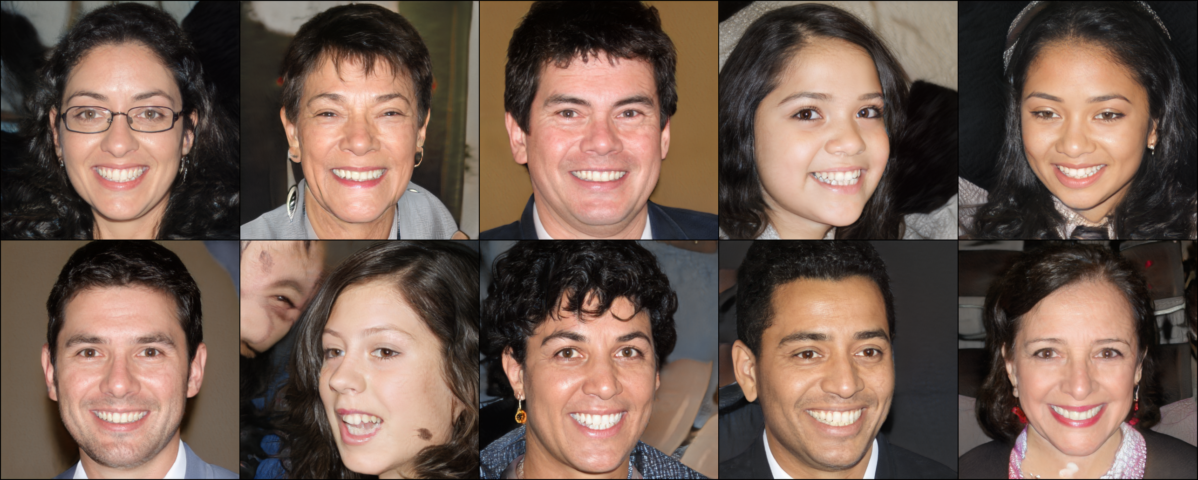

In [ ]:
from gan_control.utils.spherical_harmonics_utils import sh_eval_basis_1
strength = 0.5
illumination_control = torch.tensor([sh_eval_basis_1(0, 0, 1)]) * strength # Front Facing Illumunation

attributes_df = pd.read_pickle('/content/gan-control/resources/ffhq_1K_attributes_samples_df.pkl')
expressions = attributes_df.expression3d.to_list()
print(f'Total number of facial expression: {len(expressions)}')

facial_expression = torch.tensor([expressions[10]]) # Big smile :)
black_hair = torch.tensor([[0.08 , 0.08 , 0.08]])

image_tensors, _, modified_latent_w = controller.gen_batch_by_controls(
    latent=initial_latent_w,
    input_is_latent=True,
    expression=facial_expression,
    hair=black_hair,
    gamma=illumination_control
)

controller.make_resized_grid_image(image_tensors, resize=resize, nrow=nrow)

## Why using Pretrained Model?

Using pretrained models in GANs for disentanglement and controling features is advantageous due to the efficiency and robustness they provide. Pretrained models reduce the need for extensive computational resources, expedite the training process, and enhance performance, and limited data. In some dataset, there might not be enough information to train model to distinguish features. Pretrain models facilitate feature extraction for controlled manipulation of attributes and stabilize the training of GANs, which can take a really long time and limited computation power is the biggest contrain.

Leveraging pretrained models in GANs for feature disentanglement and control offers substantial benefits in terms of efficiency and effectiveness. These models diminish the requirement for vast computational resources and accelerate the training process. By aiding in precise feature extraction and attribute manipulation, these models contribute to the stability of GAN training.

GAN training can be time-intensive and is often constrained by available computational power. We learned our lession from complete the Part 1 of the project. We have limited resource to train GAN to satisfied the requirement. Thus, pretrained models not only optimize the training process but also address major challenges associated with resource limitations in GAN development.

---

## Comparing with StarGAN

StarGAN is another state-of-the-art and recommended model that allows for multi-domain image-to-image translation using only a single model architecture. Its forte lies in effectively transitioning images across a range of domains using a unified parameter set. However, during our exploration with StarGAN, specifically with its original codebase `(available at https://github.com/yunjey/stargan)`, we encountered limitations in handling multiple disentangled features simultaneously. While its pretrained model performed admirably for individual attributes, our project demanded a solution that could manage multiple features within the same image.

This realization led us to pivot towards other models, with a preference for pretrained solutions that could offer more control over various attributes within a single image framework.

We encountered GAN-Control, a model that excels in the delicate and detailed manipulation of multiple attributes, such as age and expression, within images. Its ability to control attributes is impressively detailed, providing the granular adjustment we required.

Despite StarGAN's commendable adaptability in domain translation, which negates the need for multiple model training for different domains, it didn't align perfectly with our project goals. For Part 2 of Project 4 - Face Generation, we sought a model like GAN-Control that could offer precise and refined control of specific image attributes within a single image.

---

Submitted By:<br>
Chanon Charuchinda 6322770692 <br>
Apichaya Snguanwongwan 6322771138<br>
Papichaya Wungpichayasuk 6322771575<br>

# END of the theory

In [ ]:
!git clone https://github.com/chanonchacharu/FaceGenerationWebsite.git
%cd FaceGenerationWebsite
!pip install pyngrok
clear_output()

In [ ]:
import random
import os

def generate_image(
    batch_size: int = 4,
    truncation: float = 0.7,
    resize: int = 480,
):
    # Ensure these global variables are initialized
    global controller, expressions, sh_eval_basis_1

    # Generate Initial Images
    initial_image_tensors, initial_latent_z, initial_latent_w = controller.gen_batch(
        batch_size=batch_size,
        truncation=truncation
    )
    nrow = batch_size // 2
    initial_image = controller.make_resized_grid_image(initial_image_tensors, resize=resize, nrow=nrow)

    # Save the initial set of images
    initial_image.save('/content/FaceGenerationWebsite/static/initial_image.png')

    # Randomize disentangling features
    pose_control = torch.tensor([[random.uniform(0, 30), random.uniform(-30, 30), 0.0]])
    age_control = torch.tensor([[random.uniform(18, 80)]])
    hair_color = torch.tensor([[random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]])
    facial_expression_index = random.randint(0, 999)  # Assuming you have 1000 expressions
    facial_expression = torch.tensor([expressions[facial_expression_index]])

    strength = 0.5
    illumination_control = torch.tensor([sh_eval_basis_1(
        random.randint(0, 1), random.randint(0, 1), random.randint(0, 1) )]) * strength

    # Generate images with disentangling features
    modified_image_tensors, _, _ = controller.gen_batch_by_controls(
        latent=initial_latent_w,
        input_is_latent=True,
        orientation=pose_control,
        age=age_control,
        hair=hair_color,
        expression=facial_expression,
        gamma=illumination_control
    )
    modified_image = controller.make_resized_grid_image(modified_image_tensors, resize=resize, nrow=nrow)

    # Save the modified set of images
    modified_image.save('/content/FaceGenerationWebsite/static/modified_image.png')

    features = {
        'pose_control': pose_control[0].tolist(),
        'age_control': age_control[0].item(),
        'hair_color': hair_color[0].tolist(),
        'facial_expression_index': facial_expression_index,
        'illumination_strength': strength
    }

    return (
        'initial_image.png',
        'modified_image.png',
        features
    )



In [ ]:
from flask import Flask, render_template, request, redirect, url_for
from pyngrok import ngrok
import base64
import os

NGROK_AUTHTOKEN = 'ADD YOUR ngrok authentication token, which will be generated when you signup for a ngrok account'

app = Flask(__name__)

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/generate')
def generate_page():
    return render_template('generate.html')

@app.route('/generate-image', methods=['POST'])
def generate_images():
    initial_image_path, modified_image_path, features = generate_image()
    return render_template('generate.html',
                           initial_image=initial_image_path,
                           modified_image=modified_image_path,
                           features=features)


ngrok.set_auth_token(NGROK_AUTHTOKEN)
public_url = ngrok.connect(5000)
print("Public URL:", public_url, end="\n\n")
app.run(host='localhost', port=5000)

Public URL: NgrokTunnel: "https://7e88-35-225-76-209.ngrok-free.app" -> "http://localhost:5000"

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://localhost:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 12:42:55] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 12:42:56] "GET /static/download.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 12:42:56] "GET /static/download%20(1).png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 12:42:56] "GET /static/download%20(3).png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 12:42:56] "GET /static/download%20(2).png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 12:42:58] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 12:45:06] "GET /generate HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 12:45:09] "POST /generate-image HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [14/Dec/2023 12:45:10] "GET /static/initial_imag